In [ ]:
# default_exp diff_analysis_manager

In [ ]:
#export
import sys
sys.path.append('/Users/constantin/workspace/EmpiRe/nbdev/MS-EmpiRe_Python')
from ms_empire.background_distributions import *
from ms_empire.normalization import *
from ms_empire.diff_analysis import *
from ms_empire.visualizations import *
from ms_empire.benchmarking import *
from ms_empire.diffquant_utils import *

In [ ]:
import os
os.chdir("/Users/constantin/workspace/EmpiRe/nbdev/MS-EmpiRe_Python/")

In [ ]:
#export
import pandas as pd
import numpy as np

#read in proteomics datafiles, log the intensities
def read_tables(peptides_tsv, samplemap_tsv, pepheader = None, protheader = None):
    samplemap = pd.read_csv(samplemap_tsv, sep="\t")
    peps = pd.read_csv(peptides_tsv,sep="\t")

    if pepheader != None:
        peps = peps.rename(columns = {pepheader : "peptide"})
    if protheader != None:
        peps = peps.rename(columns = {protheader: "protein"})
    peps = peps.set_index("peptide")
    headers = ['protein'] + samplemap["sample"].to_list()

    for sample in samplemap["sample"]:
        peps[sample] = np.log2(peps[sample].replace(0, np.nan)*10000)

    return peps[headers], samplemap


In [ ]:
#export
import pandas as pd
from itertools import combinations
import numpy as np
import statsmodels.stats.multitest as mt
from time import time

def run_pipeline(unnormed_df, labelmap_df, minrep):
    conds = labelmap_df["condition"].unique()
    pep2prot = dict(zip(unnormed_df.index, unnormed_df['protein']))
    p2z = {}
    prots = []
    pvals = []
    fdrs = []
    fcs = []
    condpairs = []
    numpeps = []
    peps = []
    pep_pvals = []
    pep_fcs = []
    pep_prots = []
    peps_included = []
    for condpair in combinations(conds, 2):
        t_zero = time()
        print(f"start processeing condpair {condpair}")
        prot2diffions = {}
        cond_pvals = []
        c1_samples = labelmap_df[labelmap_df["condition"]== condpair[0]]
        c2_samples = labelmap_df[labelmap_df["condition"]== condpair[1]]
        df_c1 = unnormed_df.loc[:, c1_samples["sample"]].dropna(thresh=minrep, axis=0)
        df_c2 = unnormed_df.loc[:, c2_samples["sample"]].dropna(thresh=minrep, axis=0)
        idx_intersect = df_c1.index.intersection(df_c2.index)
        display(c1_samples)
        df_c1_normed = pd.DataFrame(normalize_withincond(df_c1.to_numpy().T).T, index = df_c1.index, columns = c1_samples["sample"]).loc[idx_intersect]
        df_c2_normed = pd.DataFrame(normalize_withincond(df_c2.to_numpy().T).T, index = df_c2.index, columns = c2_samples["sample"]).loc[idx_intersect]
        #plot_betweencond_fcs(df_c1, df_c2, False)
        print(f"normalized within conditions")
        shift_between_cond = get_betweencond_shift(df_c1_normed, df_c2_normed)
        print(f"shift cond 2 by {shift_between_cond}")
        df_c2_normed = df_c2_normed-shift_between_cond
        #compare_normalization("./test_data/normed_intensities.tsv", df_c1_normed, df_c2_normed)
        #plot_betweencond_fcs(df_c1_normed, df_c2_normed, False)
        #plot_betweencond_fcs(df_c1_normed, df_c2_normed, True)
        t_normalized = time()
        normed_c1 = ConditionBackgrounds(df_c1_normed, p2z)
        normed_c2 = ConditionBackgrounds(df_c2_normed, p2z)
        t_bgdist_fin = time()
        print(f"t_normalized {t_normalized-t_zero} t_bg_fin {t_bgdist_fin- t_normalized}")
        ions_to_check = normed_c1.ion2nonNanvals.keys() & normed_c2.ion2nonNanvals.keys()

        ion2diffDist = {}
        count_ions=0
        for ion in ions_to_check:
            t_ion = time()
            vals1 = normed_c1.ion2nonNanvals.get(ion)
            vals2 = normed_c2.ion2nonNanvals.get(ion)
            bgdist1 = normed_c1.ion2background.get(ion)
            bgdist2 = normed_c2.ion2background.get(ion)
            t_subtract_start = time()
            diffDist = get_subtracted_bg(ion2diffDist,normed_c1, normed_c2,ion, p2z)
            t_subtract_end = time()
            diffIon = DifferentialIon(vals1, vals2, diffDist, ion)
            t_diffion = time()
            protein = pep2prot.get(ion)
            prot_ions = prot2diffions.get(protein, set())
            prot_ions.add(diffIon)
            prot2diffions[protein] = prot_ions
            peps.append(ion)
            pep_pvals.append(diffIon.p_val)
            pep_fcs.append(diffIon.fc)
            pep_prots.append(protein)

            if count_ions%1000==0:
                print(f"checked {count_ions} of {len(ions_to_check)}")
                
            count_ions+=1
            if count_ions ==1000:
                break
            t_iterfin = time()
            #print(f"t_init {t_subtract_start-t_ion} t_diffdist {t_subtract_end -t_subtract_start} t_diffion {t_iterfin - t_ion}")



        for prot in prot2diffions.keys():
            diffprot = DifferentialProtein(prot,prot2diffions.get(prot))
            prots.append(prot)
            cond_pvals.append(diffprot.pval)
            fcs.append(diffprot.fc)
            numpeps.append(diffprot.num_ions)
            condpairs.append(get_condpairname(condpair))
            peps_included.extend(diffprot.ions)

        
        pvals.extend(cond_pvals)
        fdrs.extend(mt.multipletests(cond_pvals, method='fdr_bh', is_sorted=False, returnsorted=False)[1])
        break
    display(peps_included)
    res_df = pd.DataFrame({'condpair' : condpairs,'protein' : prots, 'fdr' : fdrs, 'pval':pvals, 'fc' : fcs, 'num_peptides' : numpeps})
    pep_df = pd.DataFrame({'peptide' : peps, 'protein' : pep_prots,'peptide_pval' : pep_pvals, 'peptide_fc' : pep_fcs})
    pep_df = pep_df[pep_df["peptide"].isin(peps_included)]
    return res_df, pep_df

In [ ]:
#export
import pandas as pd
import numpy as np

def benchmark_proteomics(peptides_tsv, samplemap_tsv, prot2org):
    unnormed_df, sample2cond_df = read_tables(peptides_tsv, samplemap_tsv)

    protein_df, peptide_df = run_pipeline(unnormed_df, sample2cond_df, 2)
    #print(protein_df)
    #plot_pvals(protein_df)
    #get_tps_fps(protein_df, prot2org)
    return protein_df, peptide_df



In [ ]:
#export
import os
os.chdir("/Users/constantin/workspace/EmpiRe/nbdev/MS-EmpiRe_Python/")
protein_df, peptide_df = benchmark_proteomics("./test_data/peptides.txt", "./test_data/samples.map", "./test_data/prot2organism.tsv")
protein_df.to_csv("./test_data/AP_protein_out.tsv", sep = "\t", index= False)
peptide_df.to_csv("./test_data/AP_peptide_out.tsv", sep = "\t", index= False)


start processeing condpair ('c1', 'c2')


,sample,condition
0,Intensity 1,c1
1,Intensity 2,c1
2,Intensity 3,c1


normalized within conditions
shift cond 2 by 0.4292988007187013
t_reformat 0.015098094940185547 t_nonan_lambda 24.577821969985962 t_ion2nonan_assign 27.330738067626953
t_intensity_selection 5.373744249343872
t_reformat 0.02045726776123047 t_nonan_lambda 25.35782289505005 t_ion2nonan_assign 28.05849599838257
t_intensity_selection 5.460569143295288
t_normalized 0.2498469352722168 t_bg_fin 66.26059603691101
checked 0 of 38188


['AVLTPNHVEFSR']

['ELPTAFDYVEFTR', 'FEEFQTDMAAHEER', 'EAIVTSEELGQDLEHVEVLQK']

['AAAQIAQALLGAEER', 'IGWLHNLGDQIGK']

['NFTMDTESSVYNFEGEDYREK']

['VFELMTSLHTK']

['LILLITQVTASEK']

['IAVVGEGR']

['LELVHHGPMAVAFEVYDDFLHYK']

['LKPDEGGEVPVLNVSYKPQK']

['GLYPAPLK']

['NEIPNSHILDQYR']

['FLTDGMLLR']

['WILSQTHNIFTQAGVR']

['HVAQFLIGTAQR', 'WVQDELHSVLGLSER']

['LSDTLVFLK', 'LNIGIVHVGAPSAALNAATR']

['NGQLAASVETAGDSELFLMK']

['GDVEEDETIPDSEQDIRPR']

['TVPPAVTGITFLSGGQSEEEASINLNAINK']

['AMQTVYLR']

['NINLIVQK', 'LTNGIWILAELR', 'MEPLNNLQVAVK', 'VNYVVQEAIVVIR']

['LLSDFFDGK']

['KLEIGFNGNR']

['LVQLQEK', 'GDSEAEALSEIK']

['DVTTSEDFFDK']

['EAAAAGLPGLAR']

['MWDPHNDPNAQGDAFK']

['MSTGTFVVSQPLNYR']

['VQTLQFHPFEAQTLISGSYDK']

['QEDFMTTMDANEEK', 'QQMLENQMEVR', 'TALPAQSAATLPAR']

['AHGGFSVFTGVGER']

['IQVTPPGFQLVFLPFADDK', 'NLEALALDLMEPEQAVDLTLPK', 'NIYVLQELDNPGAK']

['HWILPQDYDHAQAEAR']

['VPTWGPLR']

['EVDEQMLNVQNK', 'LAVNMVPFPR']

['DMMFQLLR']

['VTGEADVEFATHEDAVAAMAK']

['LITPAVVSER']

['PIPGSPFR']

['LLYPLGGQTNLR', 'VYSFLDK', 'VQRPPSAASAAPSSSK']

['GPPHLQIRPPSQDLK']

['PSSQPIMSQSLPK', 'TIIIQHENIFPSPR']

['LAETQEEISAEVAAK']

['MYQTQVSDAGLYR']

['NLWIFVSK']

['QAEMLDDLMEK']

['GYAEVVVASENSVHK']

['AFYGDTLVTGFAR']

['EGIQWEAK']

['ALLPILQWHK', 'MSSVFEDQNAATHLIR']

['ALSEALTELGYK']

['LMGFFDFFK', 'GAIVHYTILNNHVYR']

['FQQVDVSVK']

['EAPATQASSTTQLTDTQVLAAENK', 'GPIAFWAR']

['YFSESDSVLVAQGVSGAVVDK']

['LLLENYEEYAAR', 'EVTTLTADPPDGIK']

['NHSDSSTSESEVSSVSPLK']

['LYVIGTGER']

['GGNEPPPPPPPFR']

['SFSLLQEAIIPYIPTLITQLTQK']

['RNAAPPPSNTEAPPGETR']

['KTDEIVALK']

['MFGAWLGELDK']

['PTVEELYR', 'STVTLSWK']

['LLPDTINSINLDR', 'ELEEEWVK']

['DLEQPTYR']

['LMDLLGEGLK']

['ETLGSEAVSSNVIDYGHASK']

['HFAALSTNETEVAK']

['SNVSDAVAQSTR']

['YYPASPWVDNSR']

['YSPTSPTYSPTSPK']

['RSELVNWYLK']

['ESDTGLWLHNK']

['DYAFIHFDER']

['EITTSEEIAQVATISANGDSHVGK']

['ENGAFTVLVDNYVK']

['QQQLEQEQFHAFEEMIR']

['RYGASAGNVGDEGGVAPNIQTAEEALDLIVDAIK', 'AADALLLK']

['AGNELLESSAGDDASSLR', 'EFESWLER', 'ELNPEEGEMVEEK']

['ELQAMSEQLR']

['NPLMYLTGVQTDK']

['VYFQSPPGAAGEGPGGADDEGPVRR']

['IMQVNGWDMTMVTHDQAR']

['EEQLLTK']

['ELSHEDLEPPPEHIPPPPRPPK']

['AANSVSQDSSYTDFSFTIAGTAHNAHSVTQSASK', 'SQAANSVDEALAAVK']

['AGEVINQPMMMAAR']

['MTLQLIK']

['DVLEVGELAK']

['EDTFDVFR']

['AEVVQVIR']

['EAALWEMEEHQLQER']

['NDIAMAITK']

['KDPQGLGLHFYK']

['ELEDEVPILGR']

['LPQFGISTPGSDLHVNAK',
 'LDADMPEVAVEGPNGK',
 'LEVPDMNIR',
 'ISMPDVDLHLK',
 'GDFDVSVPK']

['VLAVNQENEQLMEDYEK']

['ELIFQETAR']

['LHDPQLMGIIPR', 'RATEILNLLLK']

['LLSSLGGFK', 'LTSADALRPSVVSITGPLIR']

['FDPYEHEALFHTPVEGK']

['EAFEQPQTSSTPPR', 'PSNVLINALGQVK']

['FINWFSHHLSNFQFR', 'VMFEVWR']

['GQILWFR', 'VYTFNSVR']

['EGEIAMLGGVGEENEK']

['MNINGQWEGEVNGR']

['HVGDLGNVTADK']

['VGVGTSFGLPQTR']

['YLFTGLK']

['HTNFVEFR']

['EAFGFIER', 'DVEGSTSPQIGDK', 'ATNIEVLSNTFQFTNEAR']

['LYLNETFSELR', 'PLVPEVSIK']

['SLEQIVNEYSTFSENK']

['TKPQDMISAGGESVAGITAISGKPGDK']

['NLELNDDTILNDIK']

['SPPIPLAK']

['AADLQLEMTQK']

['RFPPYYMR']

['IPEIQATMR']

['AVEYLLMGIPGDR']

['SLIEEGGDWDRR']

['ADPEAAWEPTEAEAR', 'LSEFGIR']

['LFLVQDLVDSLK']

['FGGSYIVQGLK']

['SVSTTNIAGHFNDESPLGLR']

['VDTLPYVPEPIK', 'SPLYLVSR']

['PTGTFSSGGGSVASQGFGFSSPNK']

['IPTRPFEEGK']

['LTLWYYSEER']

['AAVFLALEEQEK', 'SGLSSLAGAPSLK']

['TDISLDDPNFWQK']

['TIIPLISQCTPK']

['YHNVGLSK', 'MFIGGLSWDTTK']

['LKPLPGETMEK', 'EQGVEEHETLLLR', 'GLAGAVSELLR', 'AVSSAIAQLLGEVAQGNENYAGIAAR']

['EAAFDDAVEER']

['NGIPLELR']

['RPEPSTLENITDDK']

['ATVWDLR']

['DPLTLFEEK', 'NTPSPFIETFTEDDEASR']

['PQPDPNAEFDPDLPGGGLHR']

['GDPEWSSETDALVGSR']

['ATIEGYYQK']

['VETFSGVYK']

['EEFPAWYEK', 'FEPQVDTEAEDMISAVK']

['GIGVAASSVPMNFK', 'LEPLYSPIR', 'SLLENDQLLSHGGQDLSADAFHR']

['IQSLLDIQEK']

['ALLDASETTSTR']

['THIETVINALK']

['LVTMQIWDTAGQER']

['GVWSMPSK']

['AHGGYSVFAGVGER']

['LGAGYPMGPFELLDYVGLDTTK']

['ALIAAQLDNAIEK']

['ELSPAALEK']

['PTIILSAYQR']

['LYVELHR']

['SGYQALPWVR']

['LSESQLSFR']

['RDAALAVAEAMADK']

['VPVVQAYAFGK']

['DQQLLLLK']

['LPANLLQAQR']

['FAISENPLITLR']

['ALLLLLVGGVDQSPR']

['LFDVLHEPFLK']

['TPWLYEQEGEVEK']

['LEVGIQAMEHLIHVLQTDR']

['ELPPGVEELLNK']

['HTLGHLLSLDSYR']

['SLPSEASEQYLTK']

['IYLILEYAPR']

['ETYEALLAR']

['TLHWDTDPSVLQLHSDSDLGR']

['ETHADLWPAK', 'GSNNVALGYDEGSIIVK']

['GPTEADELMK', 'LEDFFAR']

['AVEFLASNESR']

['NLTDVSPDLDIR']

['ADNFEYSDPVDGSISR']

['AQLEQGEPVLETPVESQQHEIESR']

['LVVLGSGGVGK']

['AAQEQVLNASR']

['LLAFALADTK']

['VIGQDSSEIHFK']

['QAMHSLQVLAQVTGK']

['RNDAIINQSTFK']

['GPLATGGIK']

['PLSNQPIVTISADDK']

['LELQGPR']

['HLKPEQPADGVSAVDLEK']

['LELSVHLQPITR', 'EGSASTEVLR', 'SPTLYGISHDDLK']

['WELNSGDGAFYGPK']

['LDVEEPDSANSSFYSTR']

['TPNETTSVLEPK']

['HQVQLLGR', 'EFALSNLK']

['DLLMNLGQEITR', 'GFLTSSFWR']

['FNVLYDR']

['PNFEPPQYPYIPAHITK']

['QHAFAHIESHLDK', 'IAVIGPNGAGK']

['PSYDTETDPSEGLMNVLK']

['LGLEDFESLK']

['NDVGGGGSESQELVPR', 'EYVLLHESSDTSEIDR']

['LLLGDLAPVR']

['DVTVTAIGIGDMFHEK']

['FLMPEAYPSSPR']

['NEEPSEEEIDAPK']

['VEHNQSYSQAGITETEWTSGSSK']

['VSALPVVDEK']

['LNHFFEGVEAR']

['WMQVASLNEK']

['EDGLPTGYLFVWHK', 'ITIPPHLAYGENGTGDK']

['GAAYEIFK']

['SQPDPVDTPTSSK', 'ELFQTPGHTEELVAAGK', 'GQNLLQTQDHAK', 'AQALEDLAGFK']

['TPEPVVPTAPELRPSTSTDRPVTPK']

['VGFALDLPPR']

['LIINELSNVMEANAAR', 'WTNIPLLVK', 'VLIFPVVQQFTEAFVQALQIPDGPTSDSGFK']

['ISSSSFIEPIFPTSK']

['DYVAPTANLDQK', 'YTIENPR']

['LLAFAEAR']

['YSALNVQHQMLK']

['AVFWDIK', 'LTLEDLEDSWDR']

['MMANGILK']

['AGAAAILIR']

['IAVALEIGADLPSNHVIDR']

['LEQPDPGAVAAAAILR']

['LVSESSDVLPK', 'ASLEAAIADAEQR']

['VNDAVVTVPAYFNDSQR']

['IYLDMLNVYK']

['LLGELQEQIVQK']

['VNNEDVFHALEGVYR']

['LQIDEQLR']

['DVFFYQADDEHYIPR']

['LSLEFLEK', 'IPVSEDMLGR']

['FELQHGTEEQQEEVR']

['LHFFMPGFAPLTAR']

['NLSTFAVDGK']

['NIVEFHSDHMK', 'WAGNANELNAAYAADGYAR']

['DQVFIFLK']

['MEGGFGSDFGGSGSGK']

['NPVHNGHALLMQDTHK', 'DPAGMPHPETGK']

['LSQETEALGR']

['AYFLGYMVHR']

['DVYVPNTTYR']

['GEFVTTVQQR', 'ESAFEFLSSA']

['YLSEIDLPK']

['APGTNVAMASNQAVR', 'PIAEAPSAFTLGSEMK']

['EVGDGTTSVVIIAAELLK']

['LLSPYSPQTQETDSAVQK']

['TFANTVSWSPAGR']

['STDTGVSLPSYEEDQGSK']

['TDSDIIAK']

['DVASEVNLTAYK', 'NIVQHTTDSSLEEK', 'LTPWEQFLEK']

['QFGIDGESFELK', 'GVTNDQVDPSVDVLK']

['ALTAAITPMNK']

['PSLPLSSTMHLGPVVSK']

['LDQPMTEIVSR', 'QFLFRPWDVTK']

['NISHVHTMDFSPR']

['NPDQVYLVDYGLAYR']

['WVGTIHGAAGTVYEDLR']

['NEDVDPMAASAEYELEK']

['YYQADQLVQR', 'LQPLYETLK']

['EQITQHIADLSSK', 'GASFVTSTNPR', 'ALDLADMITR']

['TLIDDDNPPVSFVK']

['DYTSGAMLTGELK', 'ALIEVLQPLIAEHQAR']

['MEDQNIIQAPQK', 'VELILEPK']

['AELSEEALLSVLPTIR', 'YFDGSGGNNHAVEHYR']

['KPPSVTPIFLEPPPK']

['LVDAICDK']

['LWNLLMPTK']

['DASLMVTNDGATILK']

['NMDTSAVLAEIPAGPGR']

['TGEEIFGTIGMR']

['GMGTAAPAAMDPVVGQAK']

['AGLESSEGGGGPERPGAR']

['SQLEESISQLR']

['SAATLITHPFHVITLR']

['HIDPVVLK']

['YAINPHLTEDQR']

['VAIVTGGTDGIGYSTAK']

['LLSGVLFHSSPALQPAADHK']

['PMCVESFSDYPPLGR', 'LPLQDVYK']

['QQLLEQQQPQK']

['LGLEALAANHQQLFTDGR']

['AGPESDAQYQFTGIK']

['QAASTVQILGAEK']

['EAVTFLR']

['TSPYDHMLPGAEHFAEYAGR']

['GGLNTPLHESDFSGVTPQR', 'PARPDPIDMDEDELEMLSEAR']

['TVLDLAVVLFETATLR', 'GTTITLVLK', 'GVVDSDDLPLNVSR']

['VEYQEDRNDLVISETELK']

['VLHHMGGMAGLQSMMR']

['SLGPSLATDK', 'RRPQPYPYPSK']

['EYQPHVIVSTTGPNPFTTLTDR']

['NNFLPPIIAR']

['TAWVFDDK']

['FGGLAAGEDNGQR']

['NDIYVTLVQGDFDK']

['DSTFLSTLEHHLSR']

['QVYIPTYSK']

['FDILFNR']

['MQDTSVSFGYQLDLPK']

['NIPSIFNTPEPTTTQEPLVGSQK']

['ASVFVLDTVR']

['TGASFQQAQEEFSQGIFSSR']

['ITHYFIDLNK']

['ALLSAPWYLNR']

['TPLHEIALSIK', 'LETHMTPEMFR']

['PGMPYLDIVR']

['MGIVSDYEK']

['AAEEVLQTVDHYK']

['VALPDGTTVTVR']

['NLENGALQPSDLDR']

['FQEHIIQAPK']

['IGQLFFGVPPK']

['FFAGIVWQHVYEK']

['LLSVVPVPEGYSVK']

['LLEESNMELEERR']

['TQALQNTMQEWTDVR']

['NEFNLESK', 'DDEYDYLFK']

['MVGQLSEGAIAAIMQK']

['TIEIEGLR']

['IVSITER', 'PIPSTEPNVVSQATSSTAVSASK']

['VFSWGFGGYGR']

['IEEVPELPLVVEDK']

['SVQTTLQTDEVK']

['NLDLLYK']

['QDPGDNWEEGGGGGGGMEK']

['MNVEEDVQEEQSK']

['LEQLGIPR']

['NLFYLPHGLSIDK']

['SGEGSQHPFGAMNIVR']

['ILDAAGANLK']

['EYEQELSDDLHVER']

['PLEVNAIK']

['DYGPGSYGGMDR']

['LDNLLNMAYGVK']

['YSVLLPTYNER']

['AFFSPFR']

['TVYLFDR', 'AHVEGDGVVEGIIR']

['TLSADASVNTLPVVVSR']

['ASTPMFLLSR', 'AISDAMFANPK']

['NNPVHLITEEDLK']

['QPVYVVDVSK']

['APSGHLAPSPPAFDGELDLQR']

['ASPDLVPMGEWTAR']

['LLQDANYNVEK']

['AHSLLFENSDSFSEDSSTLGR']

['VEEDVASDLVMK', 'HYIFNPR']

['AIGEMDNQVSQLTSELK']

['LYSGEPHAQATLLQDSVQK']

['DQLVLNIEALR', 'EFNNLLVMGTDR']

['GAAGALMVYDITR']

['RDAEDAMDAMDGAVLDGR']

['IAILGYR']

['THHNDTELIR']

['LLDVTGGLGTDELR']

['GGSGSGPTIEEVD']

['LSPGHAAPLLPGGWVTGPPDK']

['YMGDLSGGQVLK']

['EPNLEPMVEK', 'QQVADEDEIWK', 'SEAALDQEQITAAYSVEHNQLEAHPK']

['ATAAPAGAPPQPQDLEFTK']

['LFIGNLPR', 'NYGFVHIEDK']

['AVHLQGHEGPVYAVHAVYQR']

['TVPLYESPR']

['HSNVVILTTSNITEK']

['SVTVPEAENPR', 'LIWEISGGK']

['YSGYFGGVTALSR']

['SMTPAQADLEFLENAK']

['LLMHLEEMQHTISTDEEK']

['FFEDYGLFMR']

['ELVQNLLDGK']

['MNDFYIVDR']

['FENPDLFAK']

['TGAAPIIDVVR']

['YSEIDIILLK']

['LMLSTSEYSQSPK']

['TLESSIQGLR']

['LAIIEYMPLLAGQLGVEFFDEK']

['ATNAQFDSPEILR']

['LSQIGVENTEENRR']

['LGQMVLSGVDTVLGK']

['IAEFAFEYAR']

['LQQGYNAMGFSQGGQFLR']

['TFAGNTPLHLAAGLGYPTLTR']

['VMEIVDADEK']

['DVLQGELEAVK']

['TQELPSLAQSTQR']

['GFVEPDHYVVVGAQR']

['TRDELDQFLDK']

['EGDPGTIFFFR']

['YQELPNSGPPHDR']

['GQESAGIVTSDGSSVPTFK']

['VIAGLYQR', 'KFESQDTVALLEAILDGIVDPVDSTLR']

['IEFVIETAR']

['LITASETGEQLISR']

['DLFPVGR']

['GWNWGTVK']

['TFGHLLR']

['WTEGLISASK']

['VIELTGDVTPDMK']

['ESLNLEDQIESDESELK']

['KPLTTSGFHHSEEGTSSSGSK']

['AGTQIENIDEDFR', 'VQQLVPK', 'LSGSNPYTTVTPQIINSK']

['NEINSLQSSEGLLEK', 'SLAGAAQILLK']

['ATFISVQLK']

['TTEEQVENAVDR']

['EEVGEEAIVELVENGKK']

['RNPDELAEALDER']

['ALVDGPCTQVR']

['DRDDFPVVLVGNK']

['RGEMVTFK']

['IEPSVNFLK']

['EKPPITVVGDVGGR']

['VFEVMLATDR', 'LILPVGPAGGNQMLEQYDK']

['SYLDNFIK']

['KQEVDLQQLIR']

['DHTDQTSETAPDASVPPSVK', 'TTDIVIR']

['VPLLHNFHSFLYQPDWR']

['HYYSITINYR']

['DYLHYHIK', 'ASHTAPQVLFSHR']

['VQLAEDLK']

['AMLPPNSFQGK']

['GVFPFVFEK']

['ISHWLLQQGSDLSEQK']

['EREEVDIDWSAAR']

['TVEVTLTGLEYNLTHAKK']

['MELQEIQLK']

['VVGDVAYDEAK', 'WMIQYNNLNLK']

['AFMVTDEDIR']

['GLTPTGMLPSGVLAGGR']

['NISEAFEDLSK']

['TNVLGHLQQGGAPTPFDR', 'GGSFENNWNIYK']

['SPGLYFLTAGDQGTLR']

['SAGPQSQLLASVIAEK']

['TAIPFTQEPQR']

['ELQSMADQEQVSPAAIK']

['ATVYAQLVESGR']

['DENSVELTMAEGPYK', 'LDLLEDR', 'PGINVASDWSIHLR']

['NDFQLIGIQDGYLSLLQDSGEVR']

['DYNASASTISPPSSMEEDK']

['ISVATGALEAAQGSK', 'LGHSFSLVGNK']

['SPDEVTLTSIVPTR']

['SNFVHLFVSTLHFPHEQK']

['QVIQTPLADSLPVSR']

['AGIEDIETLESLSLDQHSK']

['DGGLQNMELHGMIMLR', 'TRIEGLLAAFPK', 'LFTAESLIGLK', 'ENVNLAQIR']

['NITYLPAGQSVLLQLPQ', 'AAELIANSLATAGDGLIELR']

['MLQAPESVLAEHYQDLR']

['WEIIAEDETK']

['LIFQMPQNK']

['NSNPDEIEIDFETLK']

['PIGFEGDLR']

['DSNGAILVYDITDEDSFQK']

['SSPDMLYQYLK']

['VTFNLSK']

['LPPTSLKPDTFR']

['GTIEIVSDVK']

['GTNESLER']

['AEAESLYQSK']

['SGMIEYWTGPPHEYK', 'VYLDNLPSASMYER']

['GTDTQTPAVLSPSK', 'GPQSLFNAPR']

['FDIEGSDEADGSK']

['PLEGEMQPAINAEDADLSK']

['ALTDLVSEGR']

['EVLLFPAMKPEDK']

['VVDLMAHMASK']

['VVFPSGEVVEQK']

['LQEQVTDLR', 'LEEQMNGLK', 'ESLLAEQR']

['QVVESAYEVIK']

['HTTSIFDDFAHYEK']

['LLLAADPGGSPAQR']

['PADMVIEAYGHGQR']

['SPFTVGVAAPLDLSK']

['SIASQVGITK']

['LHYNEGLNIK']

['EAKPEDLMDSK']

['VFIPHGLIMDR']

['VDFNVPLDGK']

['AIVSSGTLGDR']

['ISQIQQLNQMPLYPTEK']

['REYYFAITMER']

['LEGLGSSEADQDGLASTVR']

['EHVEPVFGFPQFVR']

['VSHQGYSTEAEFEEPR']

['VGVQVLDR']

['VLNLPSVGSK']

['YAFGQETNVPLNNFSADQVTR']

['VYAILTHGIFSGPAISR']

['NAPVTFIVDGAVVK']

['FNQAQSGNIQSTVMLDK', 'TELISVSEVHPSR']

['IMMEFER']

['IFSAYIK']

['ILNVVGMR']

['SALALAIK']

['LYDMADVWVK']

['GSNSLPLLR']

['VHILDTESFETTFGPK']

['KPLFFGEGTVLR']

['HFELGGEK']

['LEHIAIR']

['SIEVIENR']

['PIGMGGTFIIQK']

['RVHMTWVQPR']

['LGEVVNTHGPVEPDK']

['GVMLAVDAVIAELK']

['QLAPLLPSLAPSSAR']

['FSLDAVSLK']

['GAMMSIAFK', 'HALIMDEVDGMAGNEDR', 'VFAAGEETAHMSLVDK']

['TPAYIPIR']

['GHLDALTADVK']

['LYYEGLQDK']

['HSIAQLDPEALGNIK']

['FATEDEAWAFVR']

['LPIQLESAVDTAK']

['GDYPQAMK', 'DPQALSEHLK']

['STFVLDEFK']

['AMQHAEVYYK']

['HTLLSLVR', 'SQQNDEEPVATSQLLK']

['LIEAFNEIAEDSEQFDK']

['IFNAEVLFR']

['EILAELTGR']

['LTVNPGTK']

['DITELFSQLHVSSKPEK']

['RLDVFEK']

['ISESTHNTNNANVTSADALIK']

['QEQVTAAVAHAVEQQMQK']

['ETGFVESAESDHMAIPGGNQSVLAPSR']

['AGGECITLDQLAVR']

['SIDSFGQVSHPK']

['AATAAEAVASGSGEPR']

['PVVSTEAPPIIFATPTK']

['ETTYDEIK']

['EPLPATLR', 'LFEHYYQELK']

['PSDEGSSEEPAVPSGTAR']

['STILAVDNFNGIK']

['SPILVATAVAAR']

['GKPPPLLPSVLGPAGGDR']

['FNDDFIETR']

['NPILWNVADVVIK']

['DDGSTLMEIDGDK']

['GAFGEVAVVK']

['ALEPTGQSGEAVK']

['AQFFVEDASTASALK']

['SKPELPPGLSPEATAPVTPSRPEGGEPGLSK']

['WISSGEYIQMSGR']

['HGLLVPNNTTDQELQHIR']

['VEEEIVTLR']

['FESPEVAER']

['NNSELLANLGNFVNR']

['ERPAAIPIEIK']

['VFFNILEEAR']

['VHSHSAEMEAQLSQALEELGGQK']

['LDNLLLDTEGYVK']

['VLLNIGQQMLR']

['AEQEEEGLPLPLANIK']

['EDGAISTIVLR']

['AIFSVYVVNK']

['QEALEWLIR']

['LVSPAPGPGPQPHLVITEQPK']

['DTYLLYEGR']

['HLVLAGGSK']

['SMVEQLDK']

['QLLQANPILESFGNAK', 'ELDDATEANEGLSR']

['AVDFAER']

['QLTLSGIYAHITK']

['IPLENLQIIR']

['QILHGDPLPLTR']

['SSSPAPADIAQTVQEDLR']

['VSSVLSALEGK']

['EFVSASFDK']

['VVDMEPGEFIHTLGDAHVYK']

['PLLFMDLLDER']

['SDVLQPGAEVTTDDR']

['VTAQGPGLEPSGNIANK', 'SAGQGEVLVYVEDPAGHQEEAK']

['NTFWDVDGSMVPPEWHR']

['QPTPVNIR']

['HLGLEIPAWDGPR']

['VLSGTIHAGQPVK']

['SEGQGIWALLGR']

['VAELILHGQEEEK']

['QTMQVDEHARPQTTLEQLQK']

['TQLEINGR']

['NIHLWTPTDGGSWHVDQR']

['FFNEDGVIRPYR']

['EGVLEPNPVR']

['NLTALGLNLVASGGTAK']

['SSMTFLTR']

['EPPAPAQQLQPQPVAVQGPEPAR']

['FGFQWPER']

['LLYILNPPETQVEK']

['FSTHESAAHAIVSVNGTTIEGHVVK']

['LSIPTYGLQCTR', 'EVWALVQAGIR']

['LALYQTAIESAR']

['MPFDANK']

['ILEVEFDGK', 'AFISYHDEAQK', 'GFYFELQELK']

['LIHEPSAALLAYGIGQDSPTGK']

['NQDEESQEAPELLK']

['LQLSVYTTTR']

['WPEVDDDSIEDLGEVK']

['YLAEFSSGDAR']

['VFPGSTTEDYNLIVIER']

['PVPSSSGGDAHVPHGSQVIR']

['TFSEGTHFTESHSSLSSSTFLGPGLGGK']

['SLFSSIGEVESAK']

['SDHEELSGSSTNLADHNPSSWR']

['PAVLGFEGSANK']

['GIVYAVSSDR']

['VNPAAALEELEK']

['DAEAWFNEK']

['ESYYQLMK']

['YGYTHLSAGELLR', 'NPDSQYGELIEK']

['SEDYVDIVQGNR']

['VDPLETELGVK']

['LSYLEEAVMHLDHSDPITR', 'DHMGSVMAQVR']

['ASAGHAVSIAQDDAGADDWETDPDFVNDVSEK']

['AQDEIPALSVSR']

['TPSVMEALSQPSK']

['FIFVGTLK']

['KGDLSVEEVMK']

['LLYEANLPENFR']

['LIPGSNLDSEPR']

['FQASQGENLEGK', 'VTSSIPVFDLQDGGR']

['LSSNAVSQITR']

['DYTYEELLNR']

['ESGAINTSLFVLGK']

['AGVVGPELHEQLLSAEK']

['AYEFAER']

['NFMIDTYR']

['EFRPEDQPWLLR']

['IQAAASTPTNATAASDANTGDR']

['LTLHGLQQYYIK']

['NGVQAMVEFDSVQSAQR']

['ESPLLFK']

['GYWGTNLGQPHSLATK']

['VYNVTQHAVGIVVNK']

['YAVTTGDHGIIR']

['DLEDIVGGGEYKPDK']

['LLLQVQHASK']

['ELNLAISR']

['EETPGTEWEK']

['DHYIPNTLNPVFGR']

['AENSSLNLIGK']

['YNQPFFVTSLPDDK', 'GTLTEAFPVLGGK']

['EFTLEFSR']

['TPYLGDVAVVVHPGK', 'TISASTQVQGGDFNLYENMR']

['LVSGMQHPGSAGGVYETTQHFIDIK']

['VWYVSNIDGTHIAK', 'EWFLQAAK']

['ADALQAGASQFETSAAK', 'LQQTQAQVDEVVDIMR']

['PELIEENEK']

['FQVLLAELK']

['IVLVDDR']

['LLILEYAR']

['FMTTAMYDAR']

['PSVEPSAGHDEL']

['GFTLAEVK']

['LHDNPLTDENK']

['LDVGEAMAPPSHR']

['TQLWEAQAEMENIK']

['VPIIGVGGVSSGQDALEK']

['HPEELSLLK', 'KEELIGIAYNR']

['LVVAVEEAFTHIK']

['RSAEEEAADLPTKPTK']

['VWQVTIGTR']

['HFEATDILVSK']

['EGFQVADGPLYR']

['EPPLGGVVDMR']

['TFTWLVGK']

['YVATLGVEVHPLVFHTNR']

['QIGVEHVVVYVNK']

['QSPHSNLFGVQVQYK']

['LPEDQPPGPAALHVVAR']

['EIPSATQSPISK']

['LAFTGSTEVGK']

['ITSEALLVTQQLVK']

['VNYGAYINDFK']

['HALFPELPK']

['IPIHNEDITYDELVLMMQR']

['EKEEFAVPENSSVQQFK']

['SPLAMSHASGVK']

['LTQEESFSVWDEHFK']

['NSDEADLVPAK']

['LHIPWGDNSNQQHGDK']

['VPTIFPLR']

['WYPSEDVAAPK']

['LAAAVFSLAIK']

['RGSPLLIGVR']

['WGLEEEDFQPR']

['NTVEITELPVR', 'RIIPEITAMK', 'HVDYVVDQVVGK']

['NEIIILANTTNTELK']

['IGDELDSNMELQR']

['WDLSPEQIK']

['MEDTSFPSGGNAIGVNSASSK', 'QVYGLNFGSK']

['PGVWWPDMHR']

['LRQPFFQK']

['INNVIDNLIVAPGTFEVQIEEVR', 'GTMTTGHNVADLVVILK']

['FLNLSSSPSMAVR']

['SELDQLRQEAEQLK']

['DIIALNPLYR']

['FIIQSEKPPHYLESR']

['LSAAQAELAYAETGAHDK']

['VDGEIILHLYDK']

['GFDQTINLILDESHER']

['LPQVAEEISGPLTSANK']

['GFAFVEFETK']

['GFPTIYFSPANK']

['AMEAAQLADDLK']

['IEGVLLLGEPVR']

['TDQFLVTDSGR']

['LLVVDPETDEQLQK']

['DGFVQDIQNDIHASSSLNGR']

['HNELTGDNVGPLILK']

['NGQTVSGLDANWLEHMSDHFR']

['PSNILPVTVYDQHGFR']

['NEEILNSLK']

['LQAPDSATLLEK']

['HNLEYPDFYR']

['DQAENEDGAQENTFSMDPQLER']

['EPNPPIDEVISTPGVVAR']

['NWDDVLTVDYTR']

['SLGAEPLEVDLK', 'FFTGQITAAGK']

['LAAIAESGVER']

['FNDQDIEEIVK']

['FNEVVSVLK']

['ISVSFYHVK']

['LNFSHGTHEYHAETIK']

['VIPPAGQTEDAEPISEPEK']

['PVLEYYQK']

['LRPVNPNPLATK']

['LSASLPDTVGQLK']

['EYRPETGSWVFK', 'NSPVEAVFSYLTGK']

['LTLGEALQHPFFAR']

['YDLSGRPLNIK']

['DGPSLLVVEQVR']

['LTNFPEMMNR']

['PYTETVDSDGRPDEVVAEEAWQR']

['PHSALPEEVQELFIR']

['NPMDLSTIK']

['IEYNESMK', 'QEYLNEYEAEK']

['VEILANDQGNR']

['FNNGVVIAADTR']

['ILISLATGHR']

['SSTDFSELEQPR']

['LVAGDEGGSLVEPRSR']

['TDNTGTLPEDVAFR']

['VVDPFTR']

['VTFGLNR']

['IGIVEISPK']

['FLTVMMK']

['VVNVSSIMSVR']

['TLASENIPSLPPGGELASK']

['EDLTEIR']

['ELPQVSFVK']

['NVGQFSGFPFEK', 'VYENYPTYDLTER']

['LIQSLPPTLK']

['QTDVLQQLSIQMANAK']

['MDPNTIIEALR']

['IYQYVINK', 'GIIASSVGTILK']

['TDIIRPEDLDEER']

['QGPVSQSATQQPVTADK']

['GDIAHIYDIQTGNK']

['ITLVSAAPGK']

['MNVDHEVNLLVEEIHR']

['GEAEDILETEK', 'QLIMQSEMR']

['SLLEVVVLSR']

['EPFHSILSVLK']

['NGDLPWPPLR']

['QLTVTQQSQEEVAR']

['IDPQTGWPFFVDHNSR']

['LIHPFIDPLTR']

['QWLNSGHINDVR']

['IPAVTYPK']

['ILDHQQQMTVLDQTK']

['HAEPEQNWEAVDGSQTETEK']

['FGNEVIPVTVTVK']

['IQAGEGETAVLNQLQEK']

['VVHIMDFQR']

['LTPVLLAK']

['VHILGSFQNIK']

['SELEQLRQEAEQLR']

['MEAHNQFLK']

['NELHNLLDK']

['DAMLELNASNDR']

['LNDAVEYVSGR']

['LPPPPPPPLPR']

['VPVSVNLLSK']

['LVNLQHLDLLNNK']

['LQELEANPPSDVYLSSR']

['TQSQLAVQIR']

['TPNLNPNPLINVR']

['GLGATLLR']

['PYTLMSMVANLLYEK']

['SAYGGLQTSSYLMSTR']

['LEEVLTNK']

['LAFAFGDR']

['YFEYIMAK', 'DPEGFVGHPVNAFK']

['RGFAFVTFDDHDTVDK']

['LMLLDATFR']

['MSESLDTADPAVTGAK']

['WGGELTPAGR']

['AQSYDIQAWK']

['EDPLLTPVPASENPFR']

['DGQLQPVLR']

['VETGILRPGMVVTFAPVNITTEVK']

['ITSQLIVPDSFEK']

['QASHAQLGDAYDQEIR', 'SYTLDSLGNPSAYR']

['YPPIVASMTADSK']

['DIDNNLITSTPR']

['ADIPLPEGEASPPAPPLK']

['RPLQEGDIVNVDITLYR']

['VAVVLMDTQGAFDSQSTVK']

['MPNVPNTQPAIMK']

['SGAYLIPLLER']

['TALVHDGLAR']

['GPSPFSPVQLHQLR']

['MPETDFLIIR']

['FIQSEMSEAVER']

['GVGLGEALVK']

['YHSLAPMYYR']

['TEFTVEVYETHAR']

['ALAAQNIVEDMEQR']

['FVINYDYPNSSEDYIHR']

['ELNFWAK']

['VLPGGDTYMHEGFER']

['PMSPMQYAR']

['QLLAGGIAGAVSR']

['IFHGSEYK']

['QLPLEPESPSGQVGPR']

['VDELISSAIFHFK']

['TGIGVQLK', 'KPEHELFLVYGK']

['FLIPNASQAESK']

['AVTGTHTLALAAK']

['EGDFNNLTAAAFHK']

['MDETDASSAVK']

['ETVNALISDQK']

['TLFTENHLGLHSGNFSR']

['TATLRPYLSAVR']

['LDTVVEFPIR']

['GPMTGGIQGPGPINIGAGGPPQGPR']

['EIQAPASADIR']

['GTIQVITQGTSLK']

['QATLEGLQEVVGR']

['FLPFSFEHIR']

['AEAVVNTVDISER']

['RPLILQLVHVSQEDK']

['IYIGDQVQK']

['VYALPEDLVEVKPK']

['LGLQHLR']

['ESDYFTPQGEFR']

['YLNEIKPPIIHYDLK']

['EDDALWPPPDR']

['VFNPYTEFK']

['AVLTPNHVEFSR',
 'ELPTAFDYVEFTR',
 'FEEFQTDMAAHEER',
 'EAIVTSEELGQDLEHVEVLQK',
 'AAAQIAQALLGAEER',
 'IGWLHNLGDQIGK',
 'NFTMDTESSVYNFEGEDYREK',
 'VFELMTSLHTK',
 'LILLITQVTASEK',
 'IAVVGEGR',
 'LELVHHGPMAVAFEVYDDFLHYK',
 'LKPDEGGEVPVLNVSYKPQK',
 'GLYPAPLK',
 'NEIPNSHILDQYR',
 'FLTDGMLLR',
 'WILSQTHNIFTQAGVR',
 'HVAQFLIGTAQR',
 'WVQDELHSVLGLSER',
 'LSDTLVFLK',
 'LNIGIVHVGAPSAALNAATR',
 'NGQLAASVETAGDSELFLMK',
 'GDVEEDETIPDSEQDIRPR',
 'TVPPAVTGITFLSGGQSEEEASINLNAINK',
 'AMQTVYLR',
 'NINLIVQK',
 'LTNGIWILAELR',
 'MEPLNNLQVAVK',
 'VNYVVQEAIVVIR',
 'LLSDFFDGK',
 'KLEIGFNGNR',
 'LVQLQEK',
 'GDSEAEALSEIK',
 'DVTTSEDFFDK',
 'EAAAAGLPGLAR',
 'MWDPHNDPNAQGDAFK',
 'MSTGTFVVSQPLNYR',
 'VQTLQFHPFEAQTLISGSYDK',
 'QEDFMTTMDANEEK',
 'QQMLENQMEVR',
 'TALPAQSAATLPAR',
 'AHGGFSVFTGVGER',
 'IQVTPPGFQLVFLPFADDK',
 'NLEALALDLMEPEQAVDLTLPK',
 'NIYVLQELDNPGAK',
 'HWILPQDYDHAQAEAR',
 'VPTWGPLR',
 'EVDEQMLNVQNK',
 'LAVNMVPFPR',
 'DMMFQLLR',
 'VTGEADVEFATHEDAVAAMAK',
 'LITPAVVSER',
 'PIPGSPFR',
 'LLYPLGGQTNLR',
 

In [ ]:
#export
import sys
sys.path.append('/Users/constantin/workspace/EmpiRe/nbdev/MS-EmpiRe_Python')
from ms_empire.background_distributions import *
from ms_empire.normalization import *
from ms_empire.diff_analysis import *
from ms_empire.visualizations import *
from ms_empire.benchmarking import *
from ms_empire.diffquant_utils import *

In [ ]:
import os
os.chdir("/Users/constantin/workspace/EmpiRe/nbdev/MS-EmpiRe_Python/")

In [ ]:
import pandas as pd
protein_df = pd.read_csv("./test_data/AP_protein_out.tsv", sep = "\t")
peptide_df = pd.read_csv("./test_data/AP_peptide_out.tsv", sep = "\t")

,peptide,protein,peptide_pval,peptide_fc


,protein,pval_ref,fc_ref
0,O14548,0.419570,-0.437032
2,Q9UL63,0.234213,-0.165399
5,Q9H4L5,0.108981,-0.259368
11,Q9H4L4,0.938138,-0.240490
20,Q9H4L7,0.093646,-0.461974
...,...,...,...
36538,O95429,0.557536,-0.275845
36539,Q15653,0.651070,-0.264411
36541,Q15652,0.644701,0.140310
36542,Q14320,0.053926,0.089594


,protein,peptide,peptide_pval_ref,peptide_fc_ref
0,O14548,LTSDSTVYDYAGK,0.788691,0.083169
1,O14548,PVVSTEAPPIIFATPTK,0.158682,-0.957233
2,Q9UL63,SGSDFTALGFSDVDHTYAQR,0.678742,-0.215620
3,Q9UL63,AQVDPLSALK,0.738659,-0.165399
4,Q9UL63,ATIDPELNEIHVLSGLSK,0.189318,-0.825254
...,...,...,...,...
36553,Q15650,VTIDFAGR,0.871092,-0.074143
36554,Q15650,GQFIEELITK,0.698348,-0.151828
36555,Q15650,LAVLLPGR,0.790845,0.090991
36556,Q15650,KPSPQEVSELQATYR,0.375936,-0.342074


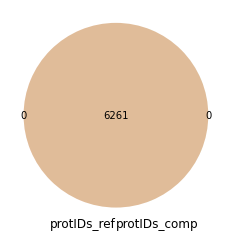

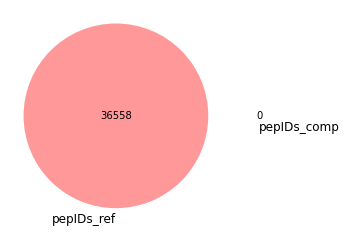

,peptide,protein,peptide_pval,peptide_fc


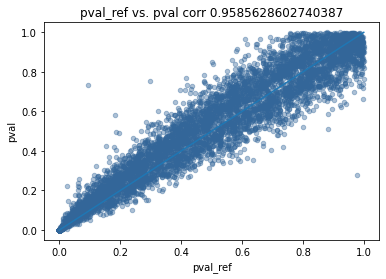

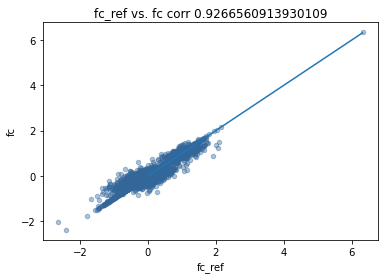

ValueError: scatter requires x column to be numeric

In [ ]:
compare_to_reference("./test_data/detail_pepinfos.tsv", protein_df, peptide_df, "./test_data/outdir/")

In [ ]:
compare_to_reference(result_df, "./test_data/reference_c1_vs_c2.tsv", "c1_VS_c2")
assigned_df = annotate_dataframe(result_df, "./test_data/prot2organism.tsv")


ref_df = pd.read_csv("./test_data/reference_c1_vs_c2.tsv", sep = "\t")
merged = pd.merge(result_df, ref_df, how='inner', on = "protein", suffixes=["", "_ref"])
display(merged)
merged["pval_diff"] = np.absolute(merged["pval"].to_numpy() - merged["pval_ref"])
merged["fc_diff"] = np.absolute(merged["fc"] - merged["log2FC_ref"])
merged = merged.sort_values(by=["pval_diff",'fc_diff'], ascending = False)
display(merged)

start processeing condpair ('A', 'B')


,sample,condition
0,A1,A
1,A2,A
2,A3,A


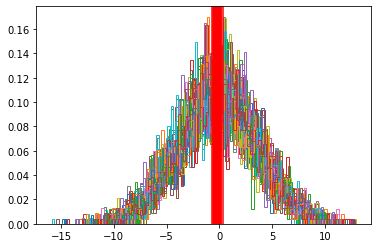

normalized within conditions
shift cond 2 by 0.17819146534180863


,Intensity 3,Intensity 2,Intensity 1,Intensity 4,Intensity 7,Intensity 6,Intensity 5
peptide,,,,,,,
KKPEDSPSDDDVLIVYELTPTAEQK,31.862269,34.240014,NaN,34.417752,33.856560,33.734586,34.531184
AGATLDLLVENMGR,36.523807,36.527461,36.499494,35.714262,35.908037,36.072114,NaN
EWFVYPGNPLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HPVIDVLLGEQDQYVPNNTDLSEDSER,34.024739,32.404937,NaN,34.716557,33.428117,34.125742,34.380485
YMFDFLDEQADK,33.720491,32.141377,NaN,NaN,32.068102,NaN,32.648138
...,...,...,...,...,...,...,...
TIEDTLMTVK,35.329811,36.184274,32.494805,NaN,NaN,NaN,NaN
VTSTLLEQDTSTEK,35.763470,35.405190,35.758977,NaN,NaN,NaN,NaN
QRVPLSDNAIIEANLGK,36.742467,36.852592,36.373280,32.636061,34.606238,34.646254,34.469273


,Intensity 3,Intensity 2,Intensity 1,Intensity 4,Intensity 7,Intensity 6,Intensity 5,A1,A2,A3,...,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12
peptide,,,,,,,,,,,,,,,,,,,,,


ValueError: scatter requires x column to be numeric

In [ ]:
import pandas as pd
import numpy as np
import uuid
import random

def test_run_pipeline():

    sample2cond_df = pd.DataFrame({'sample' : ['A1', 'A2', 'A3', 'B1', 'B2', 'B3','B4', 'B5', 'B6', 'B7', 'B8', 'B9','B10', 'B11', 'B12'],
    'condition' : ['A', 'A', 'A', 'B', 'B', 'B','B', 'B', 'B','B', 'B', 'B','B', 'B', 'B']})
    unnormed_df = generate_random_input(1000, sample2cond_df)
    res_df = run_pipeline(unnormed_df, sample2cond_df, 3)
    print(res_df)
    plot_pvals(res_df)

def generate_random_input(num_pep,sample2cond_df ):
    pepnames = list(map(lambda _idx : str(uuid.uuid4()), range(num_pep))) #gives uuid strings for each peptide
    protnames = generate_protein_list(pepnames)
    randarrays1 = 10+ 1.5*np.random.randn(num_pep,3)
    randarrays2 = 10+ 3.5*np.random.randn(num_pep,12)
    randarrays = np.concatenate((randarrays1, randarrays2), axis = 1)
    df_intens = pd.DataFrame(randarrays, columns= sample2cond_df["sample"].tolist())
    df_intens.insert(1,"protein", protnames)
    df_intens.insert(0, "peptide", pepnames )
    df_intens = df_intens.set_index("peptide")
    return df_intens

def generate_protein_list(pepnames):
    res = []
    assigned = 0
    protcount = 0
    while assigned < len(pepnames):
        protstring = f"P{protcount}"
        num_peps = random.randint(2,10)
        for i in range(num_peps):
            res.append(protstring)
        assigned+=num_peps
        protcount+=1
    res = res[:len(pepnames)]
    return res

test_run_pipeline()

In [ ]:
from scipy.stats import norm



TypeError: ppf() missing 1 required positional argument: 'q'

In [ ]:
import numpy as np
from scipy.stats import norm
fl = np.format_float_scientific(0.000000002135, 1)
print(fl)
print(norm.ppf(float(fl)))

2.1e-09
-5.876117603749608


In [ ]:
test = {}
test.get(3, "a")
print(test)

{}
